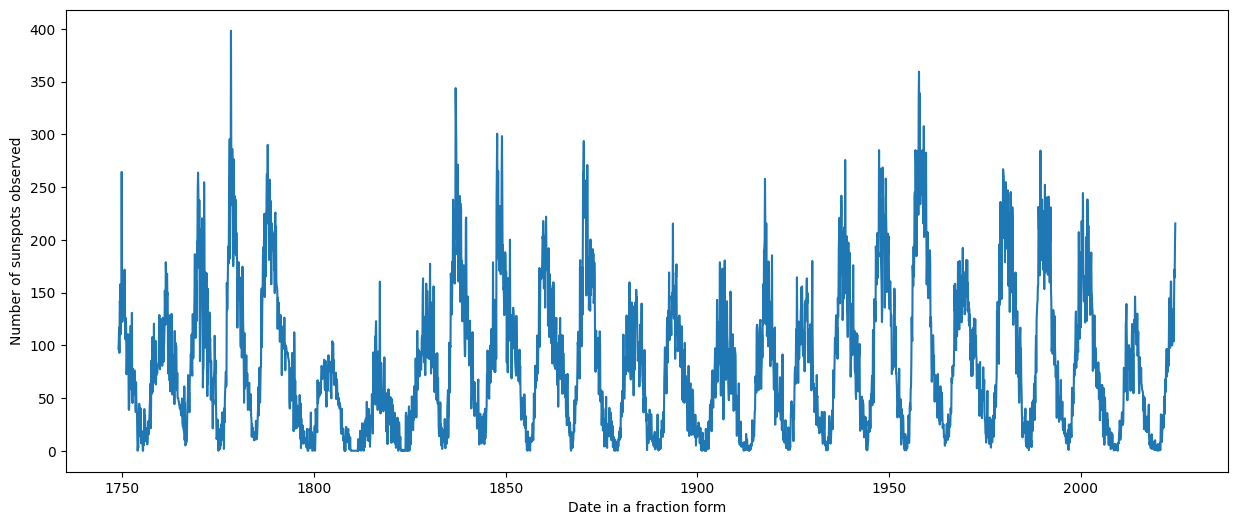

In [1]:
"""
07 Sep 2024

Jupyter notebook file used for the analysis of daily observed sunspot data

"""


import numpy as numpy
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd



%matplotlib inline


# Loading raw data from csv file
#raw_daily_sunspot_data = pd.read_csv("../data/sunspots_daily_total.csv", sep=";", header=None, na_values='-1')
raw_daily_sunspot_data = pd.read_csv("../data/sunspots_monthly_mean.csv", sep=";", header=None, na_values='-1')

# Copying the dataset so to always have an intact original copy
daily_sunspot_data = raw_daily_sunspot_data.copy()

# Give the proper names to the data columns
daily_sunspot_data.columns = ['year', 'month', 'date_in_fraction', 'number_sunspot_observed', "stan_dev", "numb_observations", "definite/provisional_indicator"]

# Remove all of the days where no data was recorded (a -1 value indicates this)
#daily_sunspot_data.replace(-1, 0)

# Create a matplotlib plot for viewing purposes
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(daily_sunspot_data["date_in_fraction"], daily_sunspot_data['number_sunspot_observed'])

ax.set_xlabel("Date in a fraction form")
ax.set_ylabel("Number of sunspots observed")
plt.show()





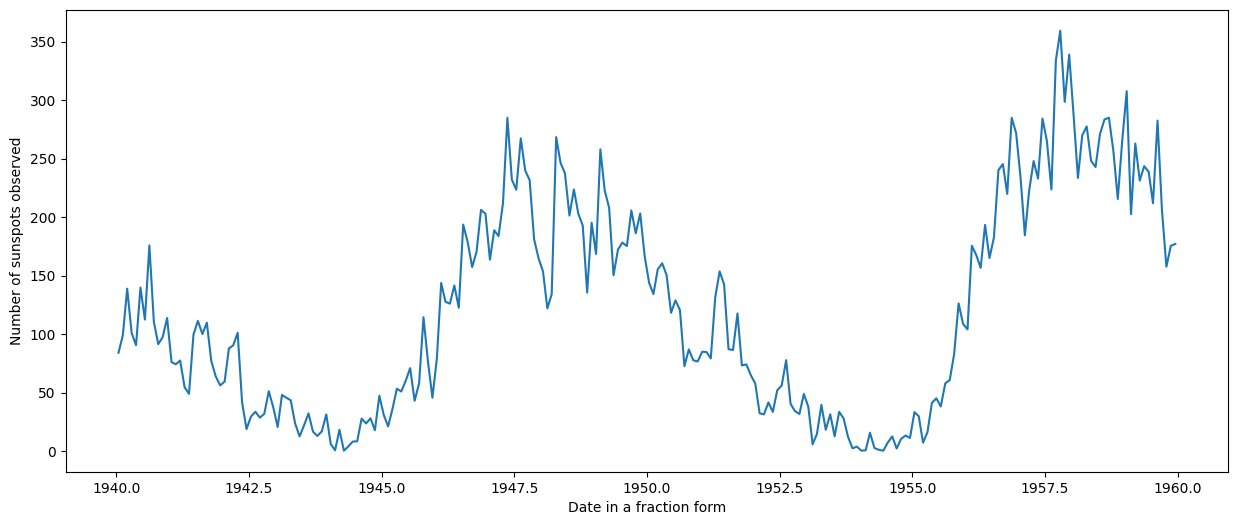

In [2]:
# Select a subset of the data set to analyze more closely
sunspot_data_subset = daily_sunspot_data.loc[(daily_sunspot_data.date_in_fraction >= 1940) & (daily_sunspot_data.date_in_fraction <= 1960)]

# Create a matplotlib plot for viewing purposes
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(sunspot_data_subset["date_in_fraction"], sunspot_data_subset['number_sunspot_observed'])

ax.set_xlabel("Date in a fraction form")
ax.set_ylabel("Number of sunspots observed")
plt.show()

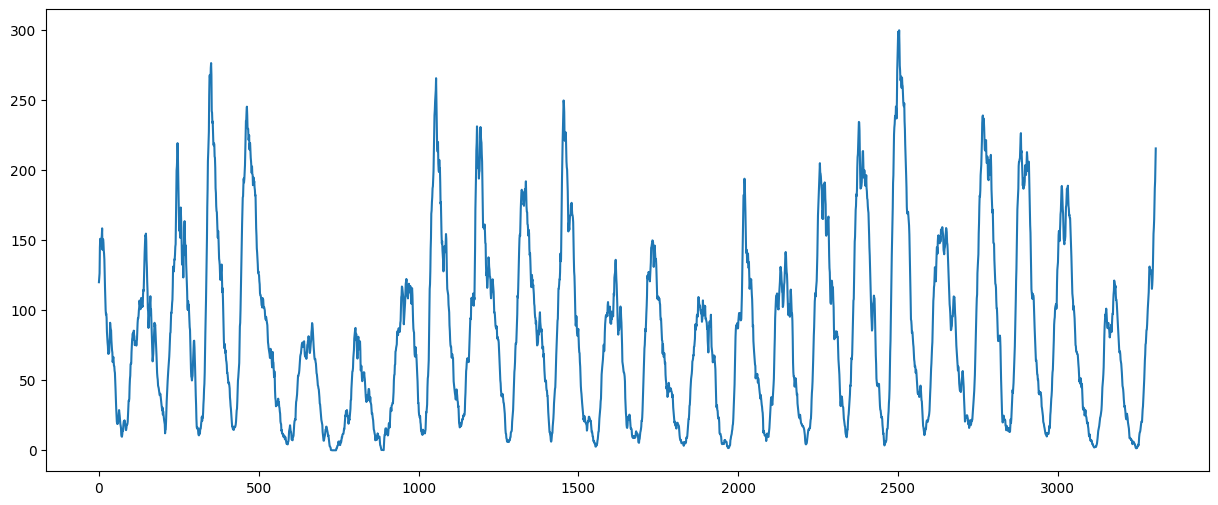

In [37]:
# Applying a moving average smoothing scheme to see if it helps the LSTM models predictive accuracy later on

timeseries_jagged = daily_sunspot_data[['number_sunspot_observed']].values.astype('float32')
timeseries = np.ones_like(timeseries_jagged)



sliding_window_size = 8
counter = 0
for slot in range(0, len(timeseries_jagged), 1):
    #print(timeseries_jagged[counter:counter+sliding_window_size].shape)
    timeseries[counter] = np.average(timeseries_jagged[counter:counter+sliding_window_size])
    counter += 1
# Create a matplotlib plot for viewing purposes
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(timeseries)

Starting
Epoch 0: train RMSE 83.3755, test RMSE 104.2523
Epoch 1: train RMSE 73.5545, test RMSE 94.2506
Epoch 2: train RMSE 65.7400, test RMSE 86.1780
Epoch 3: train RMSE 59.0496, test RMSE 79.1388
Epoch 4: train RMSE 53.3262, test RMSE 72.9618
Epoch 5: train RMSE 48.3700, test RMSE 67.4489
Epoch 6: train RMSE 43.9790, test RMSE 62.4205
Epoch 7: train RMSE 40.1451, test RMSE 57.9053
Epoch 8: train RMSE 36.7963, test RMSE 53.8324
Epoch 9: train RMSE 33.7984, test RMSE 50.0691
Epoch 10: train RMSE 31.0933, test RMSE 46.5844
Epoch 11: train RMSE 28.6491, test RMSE 43.3553
Epoch 12: train RMSE 26.3873, test RMSE 40.3083
Epoch 13: train RMSE 24.3176, test RMSE 37.4500
Epoch 14: train RMSE 22.3769, test RMSE 34.7591
Epoch 15: train RMSE 20.5890, test RMSE 32.2422
Epoch 16: train RMSE 18.9354, test RMSE 29.8892
Epoch 17: train RMSE 17.4349, test RMSE 27.7008
Epoch 18: train RMSE 15.9772, test RMSE 25.6331
Epoch 19: train RMSE 14.7174, test RMSE 23.7729
Epoch 20: train RMSE 13.5587, test RMSE 

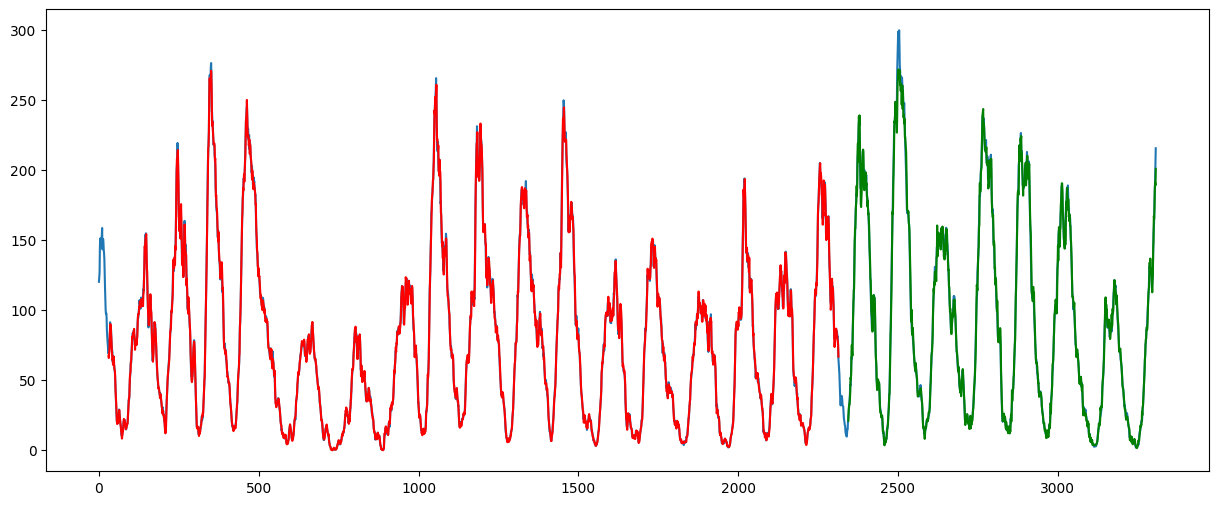

In [39]:
import torch

import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np


def create_dataset(dataset, window):
    """
    Function used for creating a bunch of batches/sequences of chunks of data of a specified window length,
    to then be utilized with the LSTM model.
    """
    X, y = [], []
    for i in range(len(dataset)-window):
        feature = dataset[i:i+window]
        target = dataset[i+1:i+window+1]

        X.append(feature)
        y.append(target)

    return torch.tensor(np.array(X)), torch.tensor(np.array(y))




train_size = int(len(timeseries) * 0.7)
test_size = len(timeseries) - train_size

train, test = timeseries[:train_size], timeseries[train_size:]


lookback_window = 30

X_train, y_train = create_dataset(train, lookback_window)
X_test, y_test = create_dataset(test, lookback_window)


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = Model()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 100
print("Starting")
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback_window:train_size] = model(X_train)[:, -1, :]
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback_window:len(timeseries)] = model(X_test)[:, -1, :]

fig, ax = plt.subplots(figsize=(15, 6))


ax.plot(timeseries)
ax.plot(train_plot, c="r")
ax.plot(test_plot, c="g")

